In [ ]:

import pandas as pd
import numpy as np 
import re  
from lib.config import connstr
from lib.utils import * 
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore') 
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn import svm
import shap 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer


from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize
import nltk
from nltk.tree import Tree 
from nltk.corpus import stopwords 
sw=stopwords.words('english') 
from nltk.util import ngrams

sentence = 'If Yes to ID9: Is the process to disable or remove unneeded accounts automated?' 
tokens = nltk.word_tokenize(sentence)
tagged_sent = nltk.pos_tag(tokens, tagset='universal')
tagged_sent

In [ ]:
sns.set(rc={'figure.figsize':(18,4.7)})
plt.style.use('dark_background')

In [ ]:
codes = ['YN','CNT','TXT','PICK','FREQ','DEC','MULTICHECKBOX' ]
qt=sql_todf(f"""
SELECT PK_QuestionTypeId, Code ,description FROM fsma_QuestionTypes
  WHERE Code IN ('YN','CNT','YNA','TXT','PICK','LABEL','FREQ','DEC','MULTICHECKBOX')
    """, connstr)   

df=sql_todf(f"""
    SELECT PK_Question, FK_QuestionType, Code, QuestionText 
    FROM fsma_Questions 
	  INNER JOIN fsma_QuestionTypes ON fsma_Questions.FK_QuestionType=fsma_QuestionTypes.PK_QuestionTypeId
	  WHERE FK_QuestionType IS NOT NULL AND QuestionText IS NOT NULL  
    AND Code IN ('{"','".join(codes)}') --  'YNA', 'FREQ','DEC',
    AND PK_Question < 40000
    ORDER BY PK_QUESTION DESC
    """, connstr)  

def normalizer(s):
    s=re.sub('[^a-z\s\-\?]','',s.lower())
    s=re.sub('\s{2,}',' ',s).strip()
    return s.upper()  
#normalizer('How many threat model exercises [34] were conducted in the last reporting period ?')
#qt
# df[df['Code'].isin(['FREQ','DEC'])]

In [ ]:
sns.barplot(df['Code'].value_counts().index, df['FK_QuestionType'].value_counts().values, alpha=0.6) 

In [294]:
 
df['QuestionText']=df['QuestionText'].apply(normalizer)  
model = LogisticRegression()

for ng in [ (1,2)]: # (1,1), (1,2), (1,3), (1,4),  
    mindf = .00275 # i*.0001   
    vectorizer = CountVectorizer(ngram_range=ng, min_df=mindf, stop_words=['in'], analyzer='word',token_pattern=u'\w+|\?')
    
    X = vectorizer.fit_transform(df['QuestionText'])   
    dff = pd.DataFrame(columns=vectorizer.get_feature_names(), data=X.toarray()) 
    dff=pd.merge(df, dff, left_index=True, right_index=True)  
    dff.drop(['QuestionText', 'PK_Question', 'Code' ], inplace=True, axis=1) 
    y = dff['FK_QuestionType'].values 
    X = dff.drop(['FK_QuestionType' ], axis=1).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    print(dff.shape)
    print (f'{ng} {mindf} {model.score(X_test, y_test)}' )   
    report = classification_report(y_test, y_pred, target_names=codes)
    print(report)

(5854, 2146)
(1, 2) 0.00275 0.950136612021858
               precision    recall  f1-score   support

           YN       0.93      0.94      0.93       366
          CNT       0.97      0.99      0.98       632
          TXT       0.97      0.98      0.97       163
         PICK       0.95      0.88      0.91       238
         FREQ       0.85      0.69      0.76        16
          DEC       0.78      0.86      0.82        21
MULTICHECKBOX       0.88      0.82      0.85        28

     accuracy                           0.95      1464
    macro avg       0.90      0.88      0.89      1464
 weighted avg       0.95      0.95      0.95      1464



In [ ]:
coefficients = abs(model.coef_[0])
coefficients[0]
fi = pd.DataFrame({'Feature': dff.columns[1:], 'Importance': coefficients})
fi = feature_importance.sort_values('Importance', ascending=False)   
plot = sns.barplot(x=fi[:20].Feature , y=fi[:20].Importance) 
plt.xticks(rotation=90)
plt.show()
#feature_importance.to_html(f'out/temp.html')

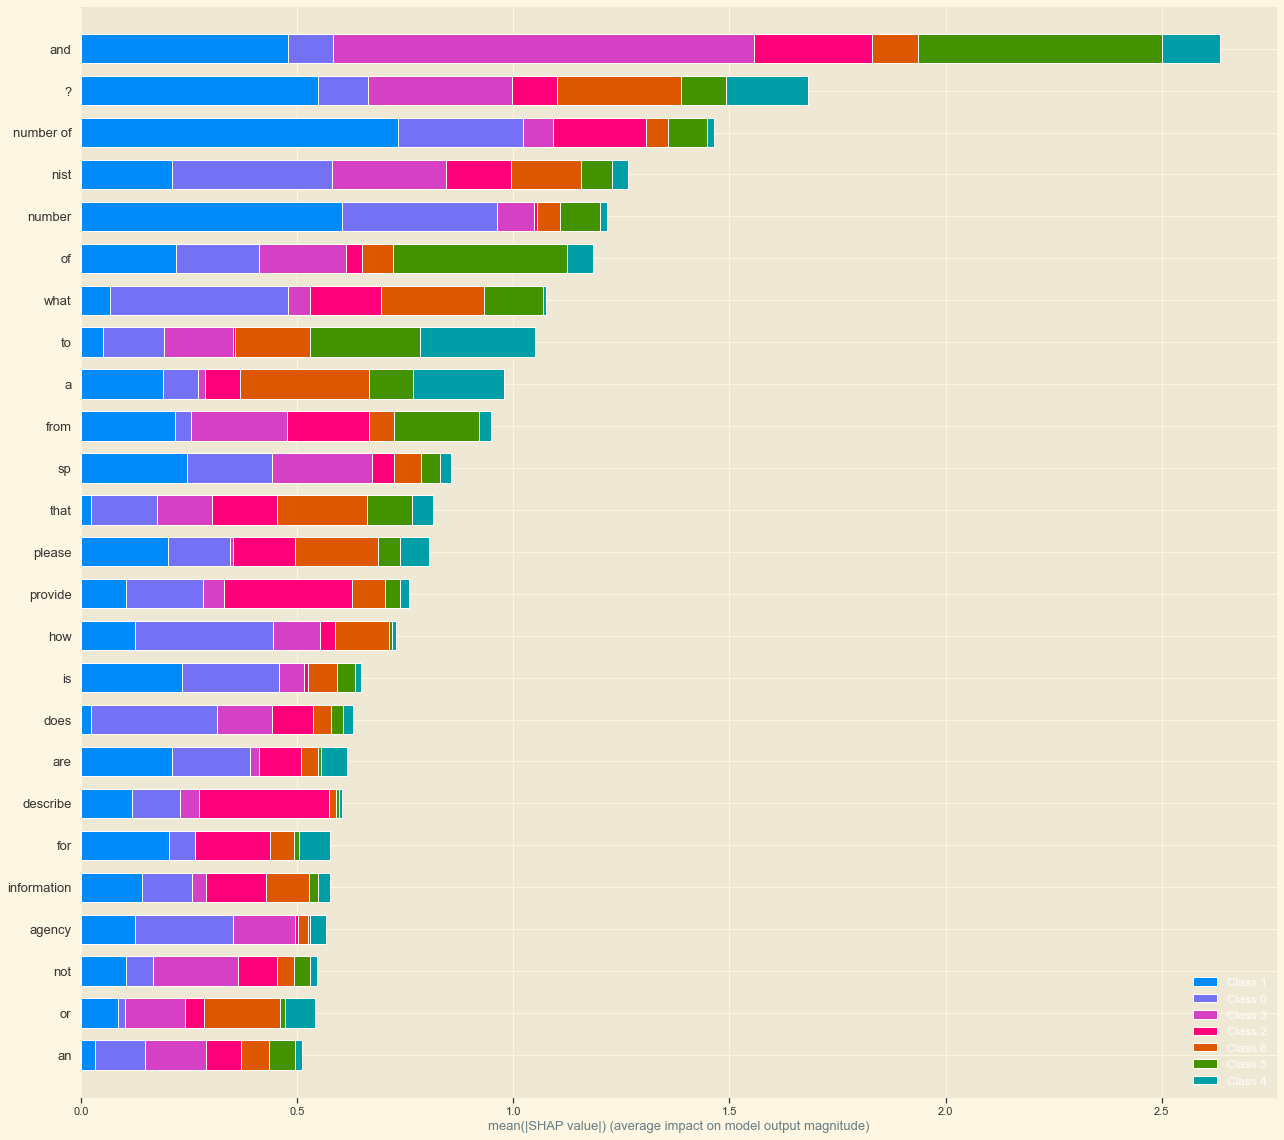

In [295]:

plt.style.use('Solarize_Light2') 
explainer = shap.Explainer(model, X_test )
shap_values = explainer.shap_values(X_test)   
shap.summary_plot( shap_values,  X_test, max_display=25,  feature_names=dff.columns[1:],  plot_size=[18,16] ) 
plt.style.use('dark_background') 

In [ ]:

df1=sql_todf(f"""
    SELECT  FK_QuestionType, Code, QuestionText 
    FROM fsma_Questions 
	  INNER JOIN fsma_QuestionTypes ON fsma_Questions.FK_QuestionType=fsma_QuestionTypes.PK_QuestionTypeId
	  WHERE FK_QuestionType IS NOT NULL AND QuestionText IS NOT NULL  
    AND Code IN ('YN', 'CNT', 'TXT', 'PICK', 'FREQ', 'DEC', 'MULTICHECKBOX') --  'YNA', 'FREQ','DEC',
    AND PK_Question > 40000
    ORDER BY PK_QUESTION DESC
    """, connstr)
print(codes)

In [ ]:
for i,r in df1[255:263].iterrows():
    print(f"{r['FK_QuestionType']} { r['QuestionText']}"  )

In [296]:
txt=normalizer('How many threat model exercises [34] were conducted in the last reporting period ?')
print(txt)
X = vectorizer.transform([txt]) 
df_predict = pd.DataFrame(columns=vectorizer.get_feature_names(), data=X.toarray())  
df_predict['?'] = 1 if '?' in txt else 0 
prediction=model.predict(X.toarray())
print ('\nPK_QuestionType : '+ str(prediction)) 

HOW MANY THREAT MODEL EXERCISES WERE CONDUCTED IN THE LAST REPORTING PERIOD ?

PK_QuestionType : [2]


In [ ]:
tokens = nltk.word_tokenize('Does the agency review and sanitize HVA logs before sharing them with external entities vendors software developers')
tagged_sent = nltk.pos_tag(tokens, tagset='universal')
tagged_sent

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 
fig, ax = plt.subplots()
tick_marks = np.arange(len(codes))
plt.xticks(tick_marks, codes)
plt.yticks(tick_marks, codes) 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g' , xticklabels=codes, yticklabels=codes) 
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
def sm_predict(s,threshold=.25): 
    s=normalizer(s)
    print ( s )
    dff=sparse_matrix.loc[:, ['FK_QuestionType','NQuestionText']]
    for i,r in dff.iterrows():  
        ratio=SequenceMatcher(None, s, str(r['NQuestionText']) ).ratio() 
        dff.loc[i, 'ratio'] = ratio
        #if ratio > threshold: break
    d=dff.loc[dff.ratio > threshold]
    d=d.sort_values(by=['ratio'], ascending=False) 
    return d
dfp=sm_predict("""

   Optionally, please provide details on the "insufficient licensing." 
    """)
dfp